<a href="https://colab.research.google.com/github/Aanvetha/Aanvetha/blob/main/Sepsisdata(EDA).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Start

In [ ]:
!pip install awscli --upgrade --quiet

In [ ]:
!mkdir -p /content/drive/MyDrive/physionet2019/
!aws s3 sync --no-sign-request s3://physionet-open/challenge-2019/1.0.0/training/ /content/drive/MyDrive/physionet2019/training/


Streaming output truncated to the last 5000 lines.
download: s3://physionet-open/challenge-2019/1.0.0/training/training_setB/p115000.psv to drive/MyDrive/physionet2019/training/training_setB/p115000.psv
download: s3://physionet-open/challenge-2019/1.0.0/training/training_setB/p115002.psv to drive/MyDrive/physionet2019/training/training_setB/p115002.psv
download: s3://physionet-open/challenge-2019/1.0.0/training/training_setB/p115003.psv to drive/MyDrive/physionet2019/training/training_setB/p115003.psv
download: s3://physionet-open/challenge-2019/1.0.0/training/training_setB/p115004.psv to drive/MyDrive/physionet2019/training/training_setB/p115004.psv
download: s3://physionet-open/challenge-2019/1.0.0/training/training_setB/p115006.psv to drive/MyDrive/physionet2019/training/training_setB/p115006.psv
download: s3://physionet-open/challenge-2019/1.0.0/training/training_setB/p115005.psv to drive/MyDrive/physionet2019/training/training_setB/p115005.psv
download: s3://physionet-open/challen

In [ ]:
!ls -lh /content/drive/MyDrive/physionet2019/training/ | head

total 8.0K
drwx------ 2 root root 4.0K Jul 28 17:37 training_setA
drwx------ 2 root root 4.0K Jul 28 17:48 training_setB


In [ ]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking

In [ ]:
data_path = "/content/drive/MyDrive/physionet2019/training/"
print("Exists:", os.path.exists(data_path))
print("Number of .psv files:", len([f for f in os.listdir(data_path) if f.endswith(".psv")]))

Exists: True
Number of .psv files: 0


In [ ]:
def load_physionet_data(paths):
    data = []
    for path in paths:
        files = [f for f in os.listdir(path) if f.endswith(".psv")]
        for f in files[:1000]:  # limit to 1000 for now
            df = pd.read_csv(os.path.join(path, f), sep="|")
            df["patient_id"] = f.replace(".psv", "")
            data.append(df)
    return pd.concat(data, ignore_index=True)

data_paths = [
    "/content/drive/MyDrive/physionet2019/training_setA",
    "/content/drive/MyDrive/physionet2019/training_setB"
]

train_df = load_physionet_data(data_paths)
train_df.head()


,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,...,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,patient_id
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,47.61,0,NaN,NaN,-358.05,1,1,p019337
1,96.0,100.0,37.50,124.5,79.0,NaN,22.0,NaN,NaN,NaN,...,NaN,101.0,47.61,0,NaN,NaN,-358.05,2,1,p019337
2,93.0,99.0,37.33,117.0,77.0,NaN,21.0,NaN,NaN,NaN,...,NaN,NaN,47.61,0,NaN,NaN,-358.05,3,1,p019337
3,95.0,99.0,NaN,127.0,83.0,NaN,20.0,NaN,NaN,NaN,...,NaN,NaN,47.61,0,NaN,NaN,-358.05,4,1,p019337
4,95.0,99.0,37.39,130.0,83.0,NaN,22.0,NaN,NaN,NaN,...,NaN,NaN,47.61,0,NaN,NaN,-358.05,5,1,p019337


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76819 entries, 0 to 76818
Data columns (total 42 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   HR                69273 non-null  float64
 1   O2Sat             66882 non-null  float64
 2   Temp              26172 non-null  float64
 3   SBP               65971 non-null  float64
 4   MAP               67163 non-null  float64
 5   DBP               53024 non-null  float64
 6   Resp              65070 non-null  float64
 7   EtCO2             2429 non-null   float64
 8   BaseExcess        4025 non-null   float64
 9   HCO3              3250 non-null   float64
 10  FiO2              6305 non-null   float64
 11  pH                5143 non-null   float64
 12  PaCO2             4128 non-null   float64
 13  SaO2              2537 non-null   float64
 14  AST               1334 non-null   float64
 15  BUN               5320 non-null   float64
 16  Alkalinephos      1320 non-null   float6

In [ ]:
train_df.describe()

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,...,WBC,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel
count,69273.000000,66882.000000,26172.000000,65971.000000,67163.000000,53024.00000,65070.000000,2429.000000,4025.000000,3250.000000,...,4947.000000,499.000000,4589.000000,76819.000000,76819.000000,46511.000000,46511.000000,76819.000000,76819.000000,76819.000000
mean,84.500317,97.180144,36.961422,123.505614,82.354712,63.87213,18.726706,31.268423,-0.976783,23.901477,...,11.278737,273.980962,195.711484,62.949157,0.559054,0.495152,0.504848,-53.388609,26.607936,0.019071
std,17.386847,2.894046,0.783455,23.280419,16.178370,13.91886,5.005111,8.385396,4.614716,4.470433,...,7.262838,134.233830,104.240078,15.816758,0.496504,0.499982,0.499982,130.139287,26.430139,0.136775
min,28.000000,20.000000,23.000000,21.000000,20.000000,20.00000,1.000000,10.000000,-23.500000,5.000000,...,0.100000,59.000000,8.000000,16.000000,0.000000,0.000000,0.000000,-1968.960000,1.000000,0.000000
25%,72.000000,96.000000,36.500000,106.500000,71.000000,54.00000,15.000000,27.000000,-3.000000,21.000000,...,7.500000,185.000000,124.000000,53.280000,0.000000,0.000000,0.000000,-49.830000,11.000000,0.000000
50%,84.000000,98.000000,37.000000,121.000000,80.000000,62.00000,18.000000,32.000000,0.000000,24.000000,...,10.200000,253.000000,178.000000,65.000000,1.000000,0.000000,1.000000,-5.970000,21.000000,0.000000
75%,96.000000,99.500000,37.500000,138.000000,92.000000,72.00000,21.500000,37.000000,1.000000,26.000000,...,13.400000,318.500000,244.000000,74.660000,1.000000,1.000000,1.000000,-0.040000,34.000000,0.000000
max,211.000000,100.000000,40.420000,272.500000,268.000000,267.00000,99.000000,98.000000,36.000000,49.000000,...,222.800000,878.000000,932.000000,100.000000,1.000000,1.000000,1.000000,22.040000,247.000000,1.000000


In [ ]:
train_df.select_dtypes(include=['object']).describe()

,patient_id
count,76819
unique,2000
top,p019602
freq,244


In [ ]:
train_df.shape

(76819, 42)

0 for people who don't have sepsis
1 for people who have sepsis

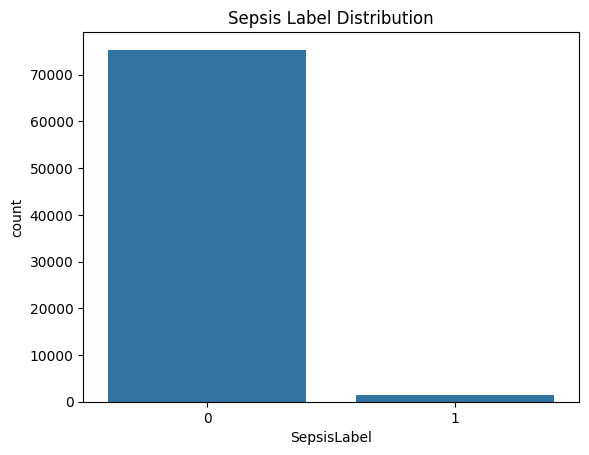

In [ ]:
# Sepsis Label Distribution
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='SepsisLabel', data=train_df)
plt.title('Sepsis Label Distribution')
plt.show()


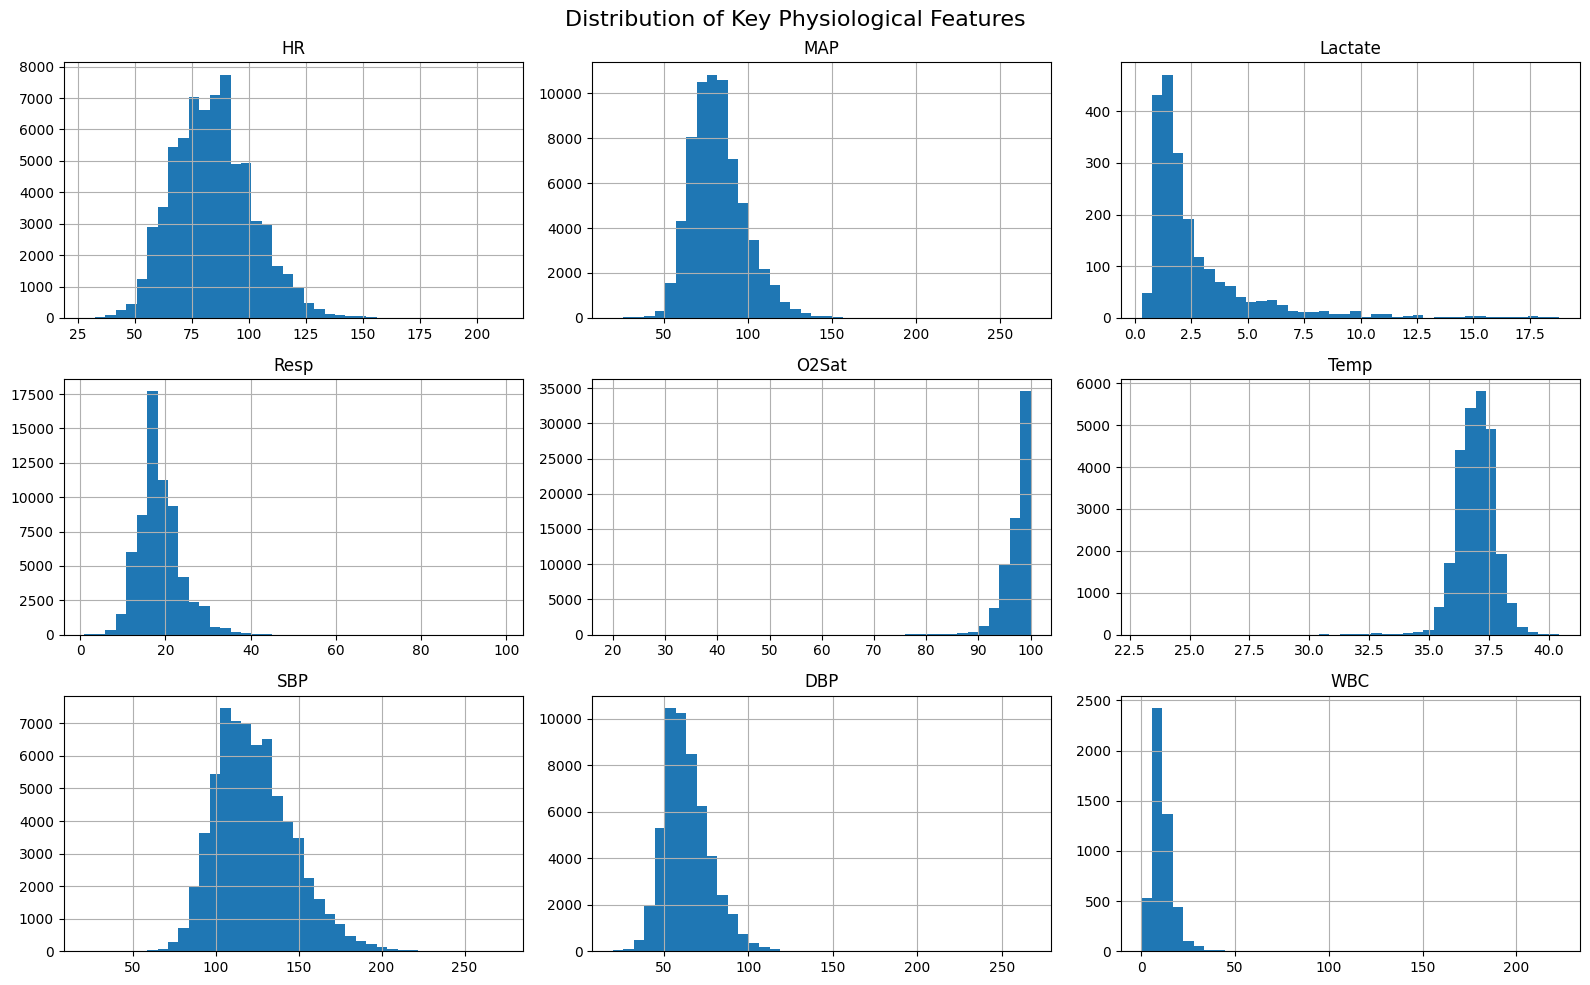

In [ ]:
# Distribution of Key Features (e.g., HeartRate, MAP, Lactate)
key_features = ['HR', 'MAP', 'Lactate', 'Resp', 'O2Sat', 'Temp', 'SBP', 'DBP', 'WBC']

train_df[key_features].hist(figsize=(16, 10), bins=40)
plt.suptitle("Distribution of Key Physiological Features", fontsize=16)
plt.tight_layout()
plt.show()

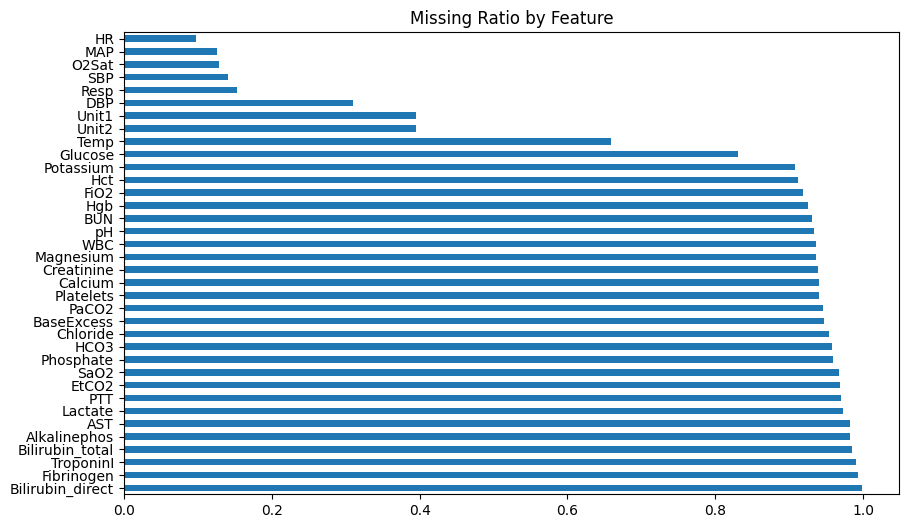

In [ ]:
#  Missing Value Analysis
missing = train_df.isnull().mean().sort_values(ascending=False)
missing[missing > 0].plot(kind='barh', figsize=(10,6), title='Missing Ratio by Feature')
plt.show()


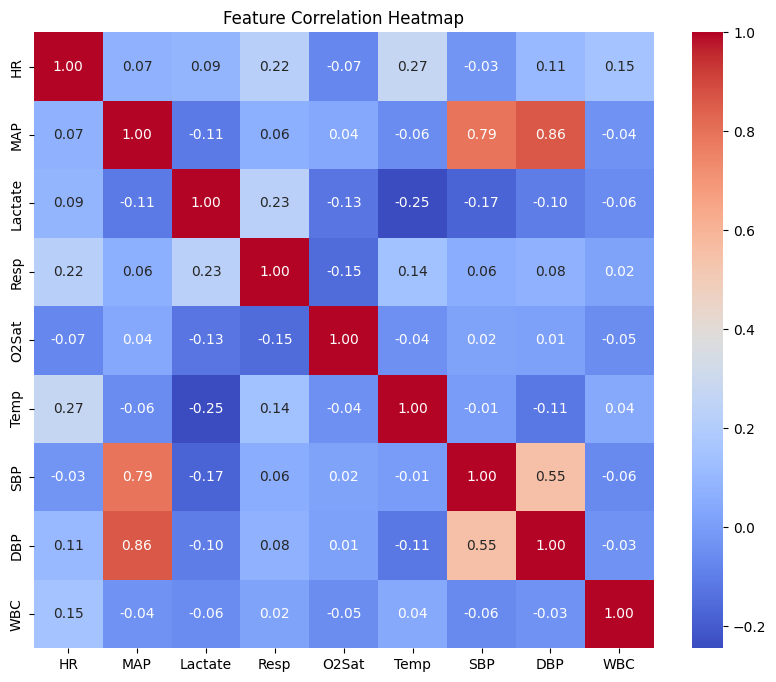

In [ ]:
# Correlation Heatmap
corr = train_df[key_features].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

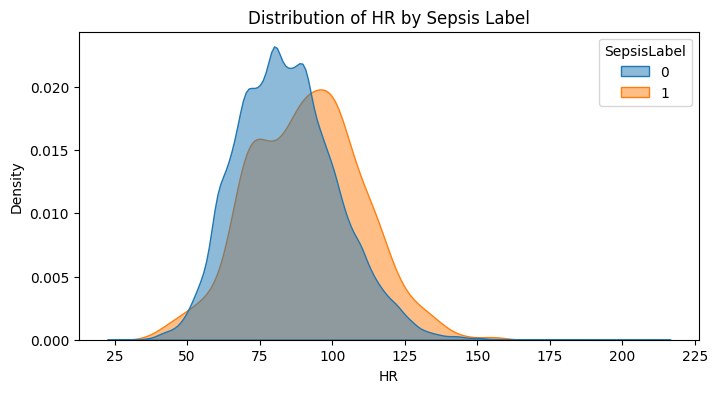

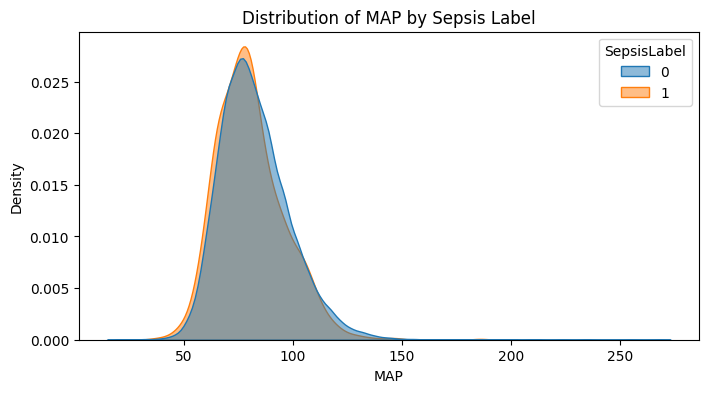

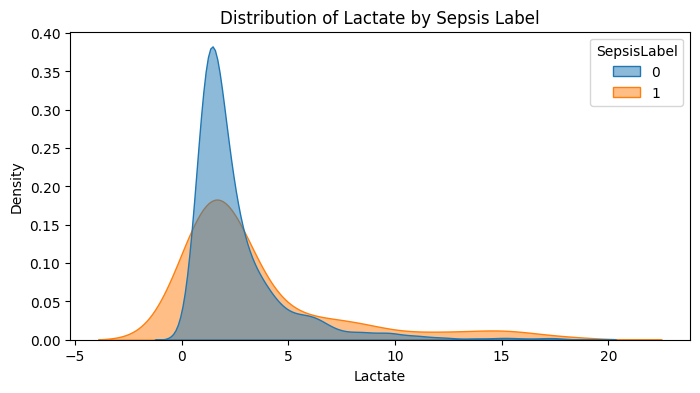

In [ ]:
# Feature Distribution by Sepsis Label
for col in ['HR', 'MAP', 'Lactate']:
    plt.figure(figsize=(8,4))
    sns.kdeplot(data=train_df, x=col, hue='SepsisLabel', fill=True, common_norm=False, alpha=0.5)
    plt.title(f'Distribution of {col} by Sepsis Label')
    plt.show()

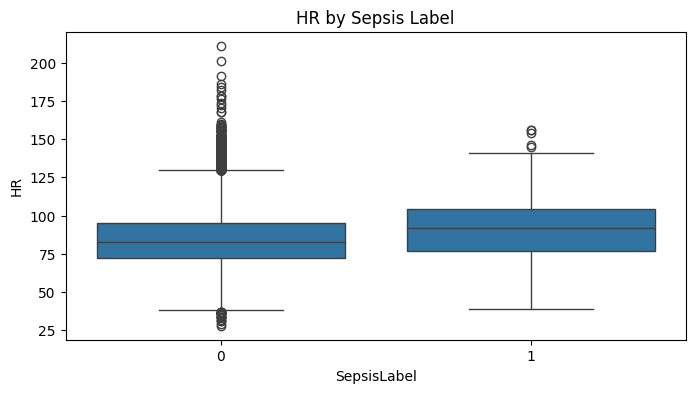

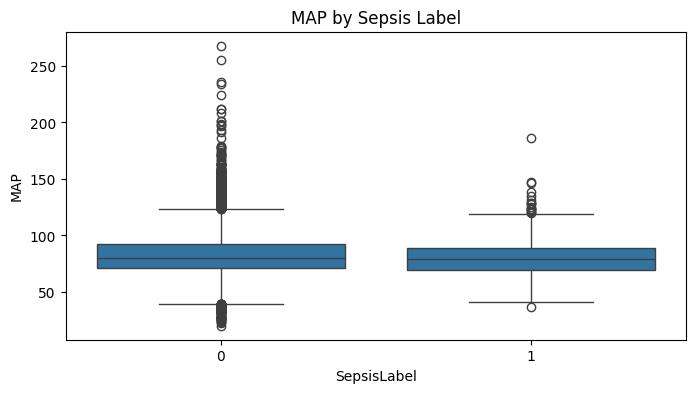

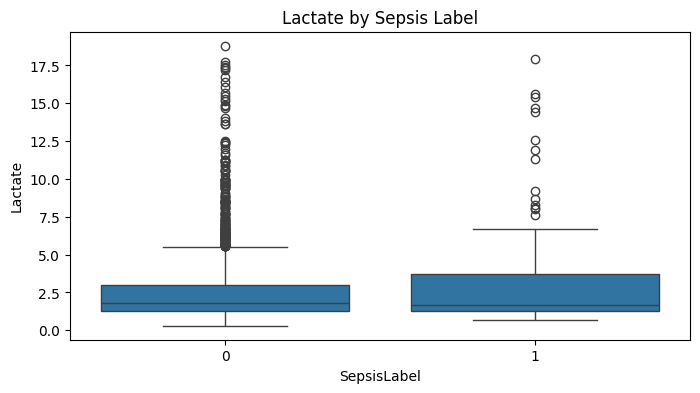

In [ ]:
# Boxplots: Sepsis vs Non-Sepsis Patients
for col in ['HR', 'MAP', 'Lactate']:
    plt.figure(figsize=(8,4))
    sns.boxplot(x='SepsisLabel', y=col, data=train_df)
    plt.title(f'{col} by Sepsis Label')
    plt.show()


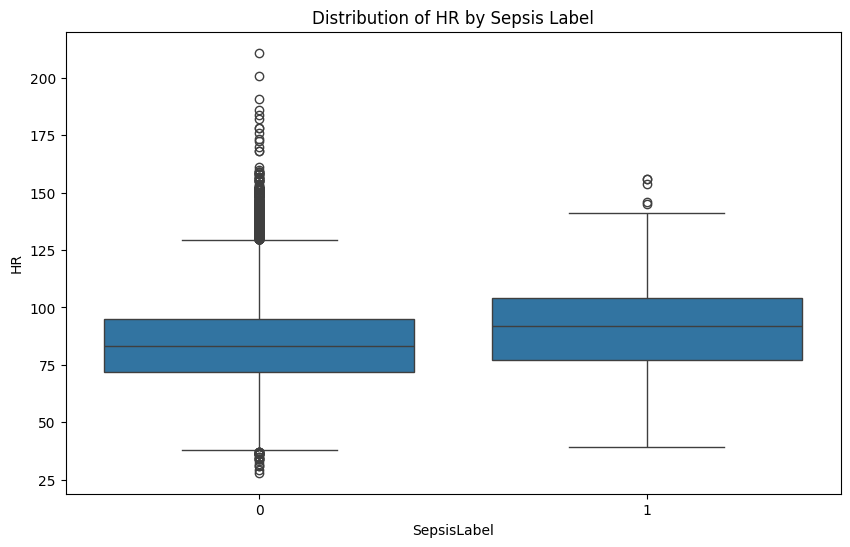

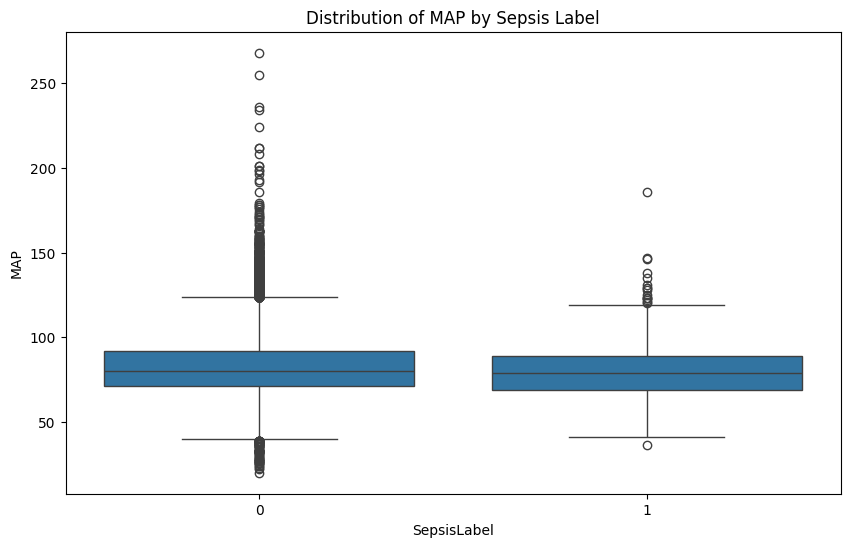

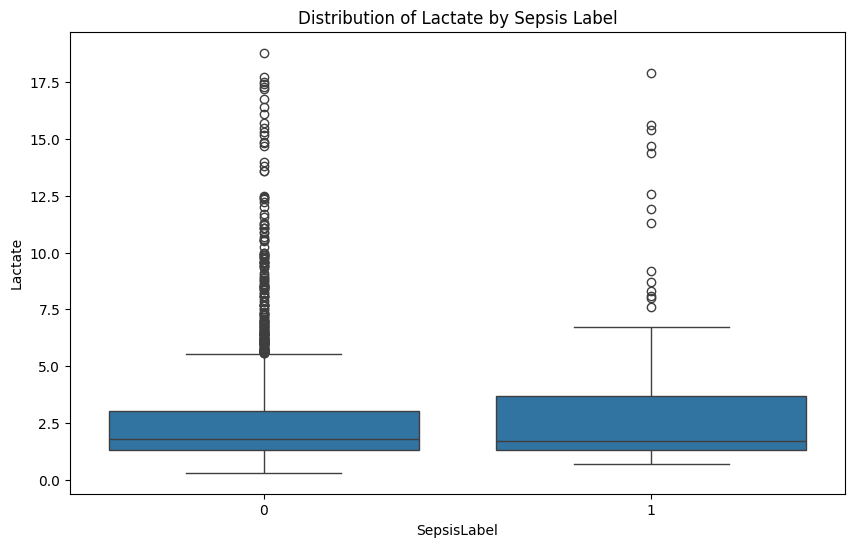

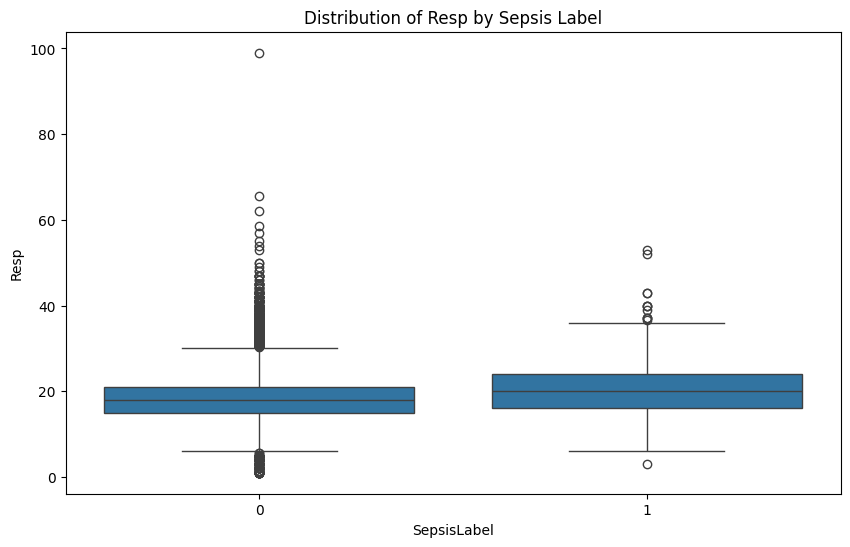

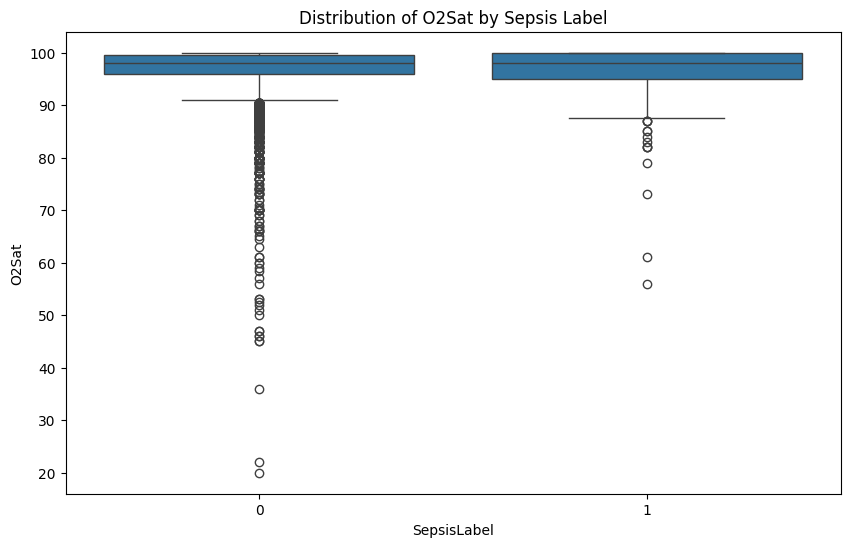

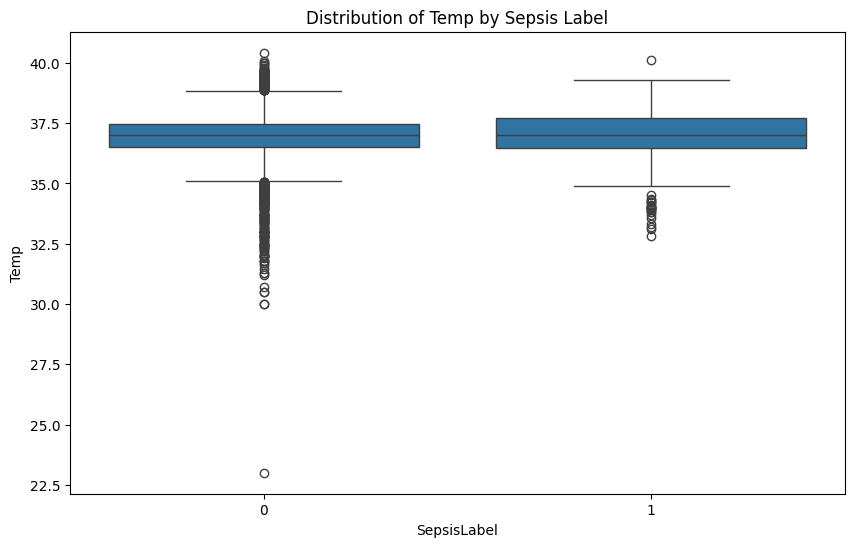

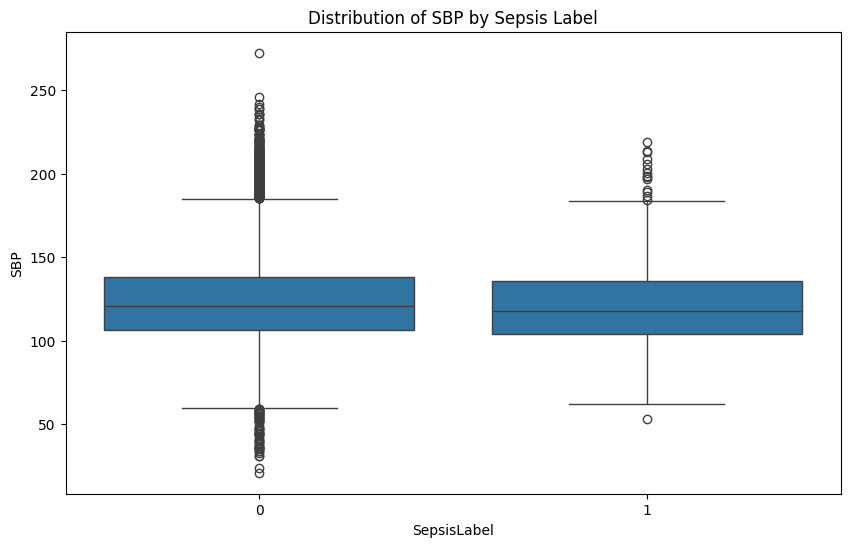

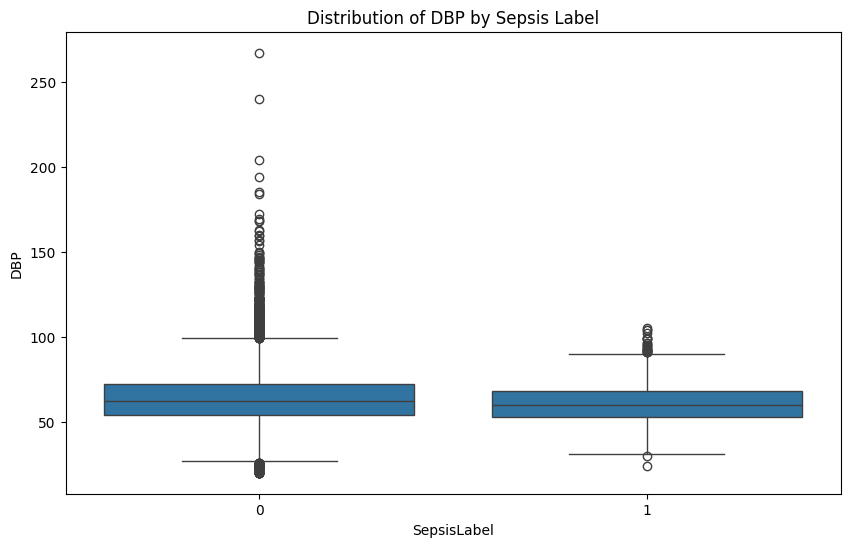

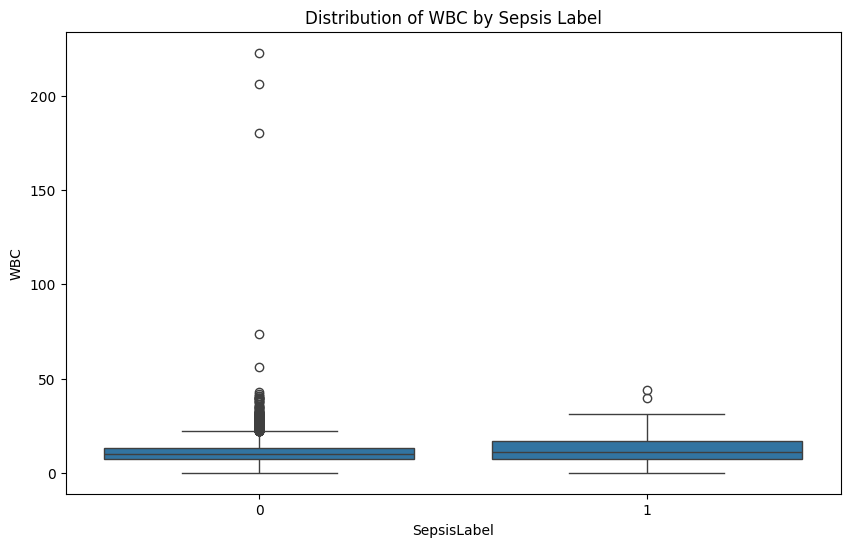

In [ ]:
for feature in key_features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='SepsisLabel', y=feature, data=train_df)
    plt.title(f'Distribution of {feature} by Sepsis Label')
    plt.show()


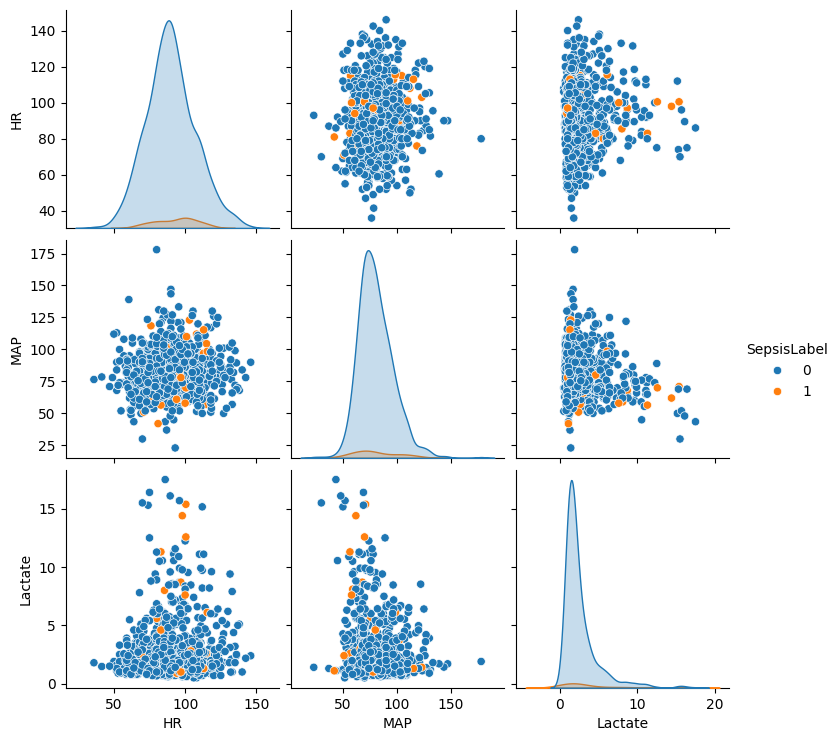

In [ ]:
subset = train_df[['HR', 'MAP', 'Lactate', 'SepsisLabel']].dropna().sample(1000)
sns.pairplot(subset, hue='SepsisLabel')

Pre processing

In [ ]:
train_df = train_df.groupby('patient_id', group_keys=False).apply(lambda df: df.ffill().bfill())



/tmp/ipython-input-187-3690505104.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_df = train_df.groupby('patient_id', group_keys=False).apply(lambda df: df.ffill().bfill())


In [ ]:
for col in train_df.select_dtypes(include='number').columns:
    train_df[col] = train_df[col].fillna(train_df[col].mean())


In [ ]:
train_df = train_df.drop(columns=['EtCO2'], errors='ignore')


In [ ]:
features = train_df.select_dtypes(include='number').columns.tolist()
if 'SepsisLabel' in features:
    features.remove('SepsisLabel')

In [ ]:
scaler = StandardScaler()
train_df[features] = scaler.fit_transform(train_df[features])


Checking for the shift labels 6 + hours earlier

In [ ]:
def shift_labels_6hr_early(df):
    def shift_group(group):
        if group['SepsisLabel'].sum() == 0:
            return group
        onset_idx = group[group['SepsisLabel'] == 1].index[0]
        early_onset_idx = max(group.index[0], onset_idx - 6)
        group.loc[early_onset_idx:onset_idx, 'SepsisLabel'] = 1
        return group

    return df.groupby('patient_id', group_keys=False).apply(shift_group).reset_index(drop=True)

train_df = shift_labels_6hr_early(train_df)
train_df.rename(columns={"SepsisLabel": "SepsisLabelFuture"}, inplace=True)


/tmp/ipython-input-192-1887014568.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby('patient_id', group_keys=False).apply(shift_group).reset_index(drop=True)


Missing values and feature

In [ ]:
train_df.interpolate(limit_direction="both", inplace=True)
train_df.fillna(method="bfill", inplace=True)
train_df.fillna(method="ffill", inplace=True)

train_df["Hypotensive"] = (train_df["MAP"] < 65).astype(int)
train_df["HighLactate"] = (train_df["Lactate"] > 2).astype(int)

/tmp/ipython-input-193-4159242937.py:1: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  train_df.interpolate(limit_direction="both", inplace=True)
/tmp/ipython-input-193-4159242937.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_df.fillna(method="bfill", inplace=True)
/tmp/ipython-input-193-4159242937.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_df.fillna(method="ffill", inplace=True)


Timeseries Daatset for pytroch Forecasting

In [ ]:
train_df["hours_in"] = train_df.groupby("patient_id").cumcount()

to know the structure

In [ ]:
print("Shape of dataset:", train_df.shape)
print("\nColumn types:\n", train_df.dtypes)
print("\nNumber of unique patients:", train_df["patient_id"].nunique())
train_df.info()

Shape of dataset: (76819, 42)

Column types:
 HR                  float64
O2Sat               float64
Temp                float64
SBP                 float64
MAP                 float64
DBP                 float64
Resp                float64
EtCO2               float64
BaseExcess          float64
HCO3                float64
FiO2                float64
pH                  float64
PaCO2               float64
SaO2                float64
AST                 float64
BUN                 float64
Alkalinephos        float64
Calcium             float64
Chloride            float64
Creatinine          float64
Bilirubin_direct    float64
Glucose             float64
Lactate             float64
Magnesium           float64
Phosphate           float64
Potassium           float64
Bilirubin_total     float64
TroponinI           float64
Hct                 float64
Hgb                 float64
PTT                 float64
WBC                 float64
Fibrinogen          float64
Platelets           float64
Ag

EDA

In [ ]:
train_df.select_dtypes(include=['object']).describe()

,patient_id
count,76819
unique,2000
top,p019602
freq,244


In [ ]:
train_df.shape

(76819, 42)

Missing Values Analysis

In [ ]:
missing = train_df.isnull().sum()
missing[missing > 0].sort_values(ascending=False)

,0
Bilirubin_direct,76689
Fibrinogen,76320
TroponinI,76075
Bilirubin_total,75621
Alkalinephos,75499
AST,75485
Lactate,74724
PTT,74554
EtCO2,74390
SaO2,74282


In [ ]:
missing = train_df.isnull().sum().sort_values(ascending=False)
missing_percentage = (missing / len(train_df)) * 100
missing_df = pd.DataFrame({'Missing Count': missing, 'Missing %': missing_percentage})
missing_df[missing_df['Missing Count'] > 0]

,Missing Count,Missing %
Bilirubin_direct,76689,99.830771
Fibrinogen,76320,99.350421
TroponinI,76075,99.031490
Bilirubin_total,75621,98.440490
Alkalinephos,75499,98.281675
AST,75485,98.263450
Lactate,74724,97.272810
PTT,74554,97.051511
EtCO2,74390,96.838022
SaO2,74282,96.697432


Distribution

<Axes: xlabel='HR', ylabel='Density'>

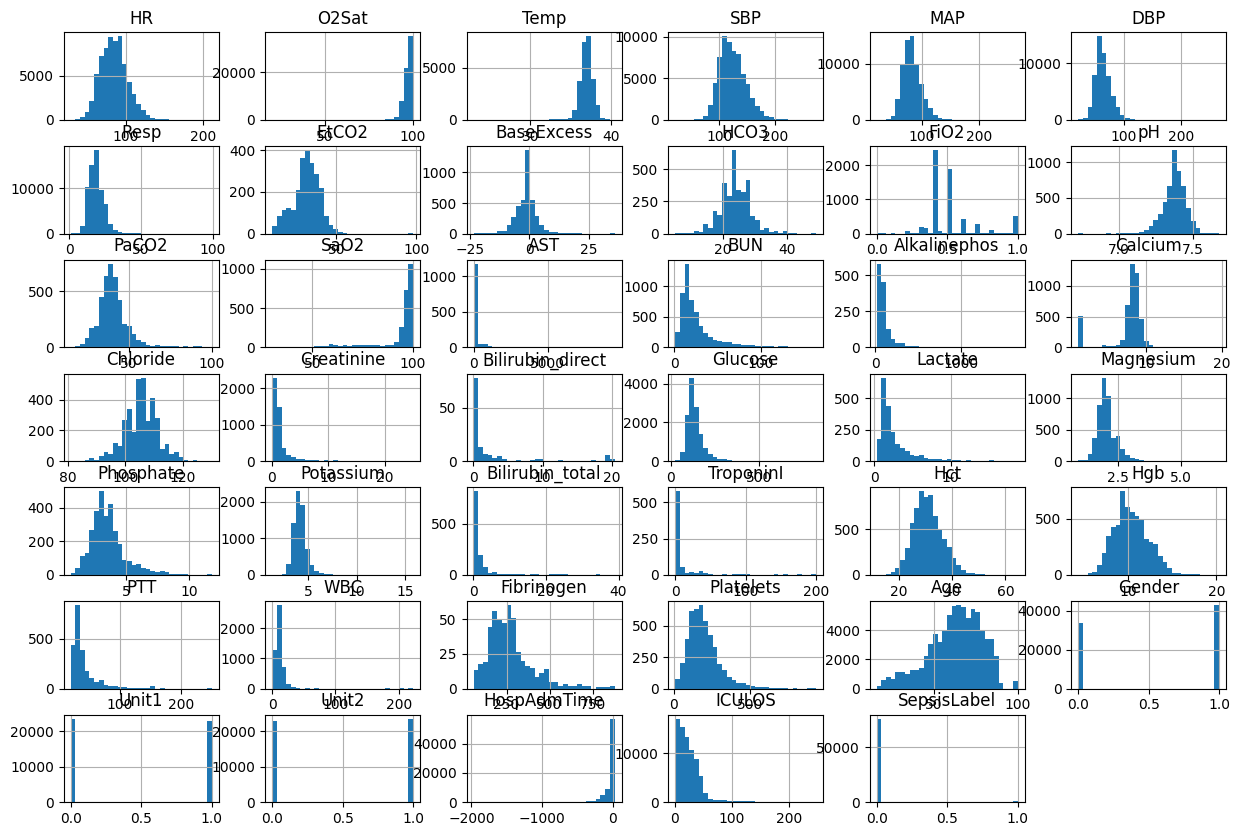

In [ ]:
train_df.hist(figsize=(15, 10), bins=30)
sns.kdeplot(train_df['HR'].dropna())

<Axes: title={'center': 'Vitals over time'}, xlabel='ICULOS'>

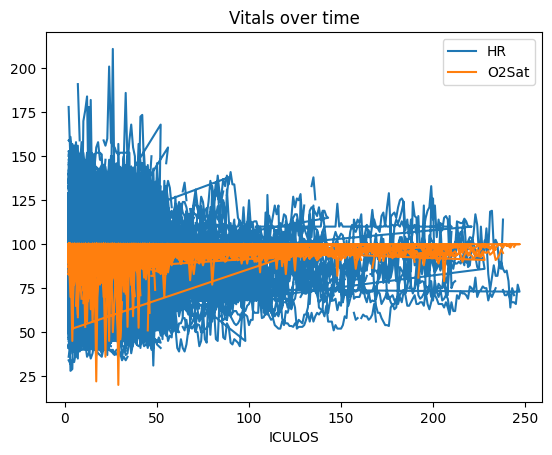

In [ ]:
train_df[['ICULOS', 'HR', 'O2Sat']].plot(x='ICULOS', title='Vitals over time')

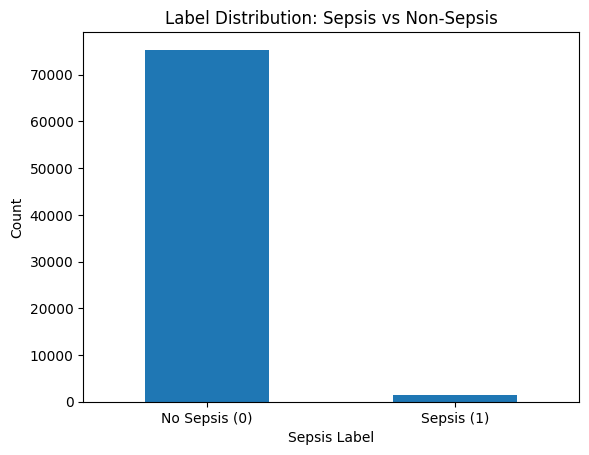

In [ ]:
train_df['SepsisLabel'].value_counts().plot(kind='bar')
plt.title('Label Distribution: Sepsis vs Non-Sepsis')
plt.xlabel('Sepsis Label')
plt.ylabel('Count')
plt.xticks([0, 1], ['No Sepsis (0)', 'Sepsis (1)'], rotation=0)
plt.show()


Correlation analysis


1. -ve (red)
2.  +ve REd
3. no correlation(white

<Axes: >

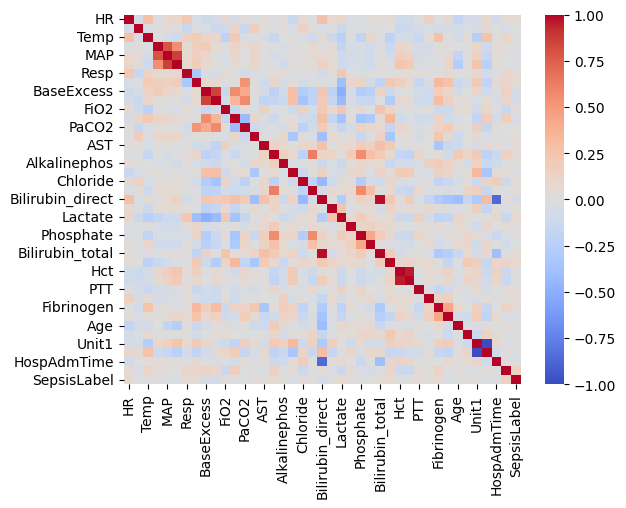

In [ ]:
corr = train_df.drop(columns=['patient_id']).corr()
sns.heatmap(corr, cmap='coolwarm')

In [ ]:
def load_physionet_data(paths):
    data = []
    for path in paths:
        files = [f for f in os.listdir(path) if f.endswith(".psv")]

for one patient missing values

In [ ]:
# Sort first
train_df = train_df.sort_values(by=['patient_id', 'ICULOS'])

# Fill missing values forward and backward per patient
train_df = train_df.groupby('patient_id', group_keys=False).apply(lambda x: x.ffill().bfill()).reset_index(drop=True)


/tmp/ipython-input-152-1162237185.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_df = train_df.groupby('patient_id', group_keys=False).apply(lambda x: x.ffill().bfill()).reset_index(drop=True)


Normalization

In [ ]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Step 1: Select features
feature_cols = train_df.select_dtypes(include='number').columns.drop(['SepsisLabel', 'ICULOS'], errors='ignore')

# Step 2: Only scale if there is data
if not train_df.empty and not train_df[feature_cols].empty:
    scaler = StandardScaler()
    train_df[feature_cols] = pd.DataFrame(
        scaler.fit_transform(train_df[feature_cols]),
        columns=feature_cols,
        index=train_df.index
    )
    print("Scaling applied.")
else:
    print("train_df is empty or has no feature columns to scale.")

train_df is empty or has no feature columns to scale.


In [ ]:
if 'patient_id' in train_df.columns and not train_df.empty:
    patient_ids = train_df['patient_id'].unique()
    if len(patient_ids) > 1:
        train_ids, val_ids = train_test_split(patient_ids, test_size=0.2, random_state=42)
        train_data = train_df[train_df['patient_id'].isin(train_ids)]
        val_data = train_df[train_df['patient_id'].isin(val_ids)]
        print(f"Train patients: {len(train_ids)}, Validation patients: {len(val_ids)}")
    else:
        print("Not enough patient IDs to split.")
else:
    print("train_df is empty or missing 'patient_id'.")




train_df is empty or missing 'patient_id'.


In [ ]:
print("train_df shape:", train_df.shape)
print("train_df columns:", train_df.columns.tolist())

# Check if feature_cols was selected properly
print("Selected feature columns:", feature_cols.tolist())

# Check if numeric data exists
print("train_df[feature_cols] shape:", train_df[feature_cols].shape)


train_df shape: (0, 41)
train_df columns: ['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2', 'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN', 'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct', 'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium', 'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC', 'Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2', 'HospAdmTime', 'ICULOS', 'SepsisLabel']
Selected feature columns: ['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2', 'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN', 'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct', 'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium', 'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC', 'Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2', 'HospAdmTime']
train_df[feature_cols] shape: (0, 39)


Load and comnbine patient data